In [55]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
import importlib
from cycler import cycler
from pathlib import Path
from matplotlib.ticker import MultipleLocator
from pathlib import Path
from numpy.polynomial.polynomial import Polynomial
import re
from scipy.integrate import simpson

# import utils
# importlib.reload(utils)

In [56]:
# Import the data
file_paths = ['Data/task 2 32C.csv', 'Data/task 2 74.1C.csv']
columns = ['Counter Voltage', 'Detector Voltage (6V)', 'Detector Voltage (9V)', 'Detector Voltage (12V)']

data_dict = {}

df = pd.read_csv(file_paths[0], header=None, names=columns)
data_dict['32 C'] = df[columns].copy()

df=pd.read_csv(file_paths[1], header=None, names=columns)
data_dict['74.1 C'] = df[columns.copy()]

R_series = 27  # Ω  (from lab manual)
for temp_key, df in data_dict.items():
    for v in (6, 9, 12):
        col_V  = f'Detector Voltage ({v}V)'
        col_I  = f'Anode Current ({v}V) [µA]'
        df[col_I] = 1e6 * df[col_V] / R_series   # µA keeps numbers ~1–100

In [58]:
def fit_function(x, a, b, c, d, e):
    return a + b * x + c * x**2 + d * x**3 + e * x**4
y_columns = ['Anode Current (6V) [µA]', 'Anode Current (9V) [µA]', 'Anode Current (12V) [µA]']
fit_results = {}


for key, data in data_dict.items():
    fit_results[key] = {}
    
    x_all = data['Counter Voltage'].values

    for y_col in y_columns:
        y_all = data[y_col].values

        mask = ~np.isnan(y_all)
        x = x_all[mask]
        y = y_all[mask]

        popt, pcov = curve_fit(fit_function, x, y)
        fit_results[key][y_col] = {
            'params': popt,
            'cov': pcov
        }

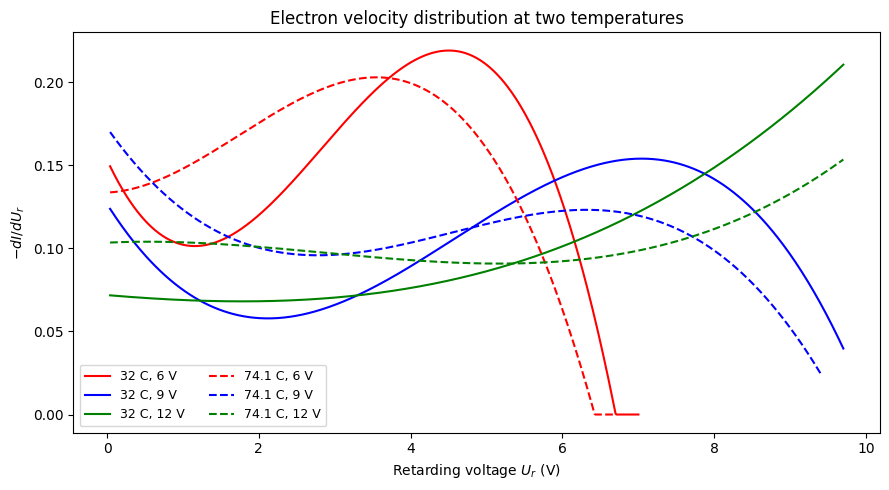

In [59]:
distros = {}  # store for later use

for temp_key, df in data_dict.items():
    distros[temp_key] = {}
    x_all = df['Counter Voltage'].values
    
    for v in (6, 9, 12):
        y_col = f'Anode Current ({v}V) [µA]'
        mask  = ~np.isnan(df[y_col].values)
        x, I  = x_all[mask], df[y_col].values[mask]
        
        # fit 4th-order poly again (or use coeffs you already saved)
        p = Polynomial.fit(x, I, 4)              # np.polynomial gives ascending powers
        dp = p.deriv()                           # analytic dI/dU_r
        
        # high-res grid for smooth curve
        x_fine = np.linspace(x.min(), x.max(), 600)
        fU = -dp(x_fine)                         # minus sign → number of electrons
        fU[fU < 0] = 0                           # clip tiny negatives
        
        # normalise area to 1
        area = simpson(fU, x_fine)
        fU_norm = fU / area
        
        distros[temp_key][v] = (x_fine, fU_norm)

colour = {6: 'red', 9: 'blue', 12: 'green'}
mark   = {'32 C': 'o', '74.1 C': '^'}

fig, ax = plt.subplots(figsize=(9,5))
ax.set(xlabel='Retarding voltage $U_r$ (V)',
       title='Electron velocity distribution at two temperatures')
ax.set_ylabel(r'$-dI/dU_r$')


for temp_key, dat in distros.items():
    for v, (x, f) in dat.items():
        ax.plot(x, f,
                color=colour[v],
                linestyle='-' if temp_key=='32 C' else '--',
                label=f'{temp_key}, {v} V')

# tidy legend (one entry per curve)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, ncol=2, fontsize=9)

plt.tight_layout(); plt.show()


  Temperature Voltage              a             b             c            d  \
0        32 C     6 V  195890.943412 -30159.160473   9652.845501 -3497.045846   
1        32 C     9 V  317062.451669 -40772.421497  11614.598956 -2376.530096   
2        32 C    12 V  411336.773256 -20963.010681    567.672084   -77.430283   
3      74.1 C     6 V  136044.895566 -18114.648444   -124.964848  -700.043100   
4      74.1 C     9 V  233835.589540 -40385.158316   7582.101726 -1311.184516   
5      74.1 C    12 V  329211.661915 -27656.749037   -297.505798   202.857959   

            e  
0  308.966101  
1  129.696099  
2   -8.106616  
3  100.314676  
4   72.128251  
5  -17.769272  


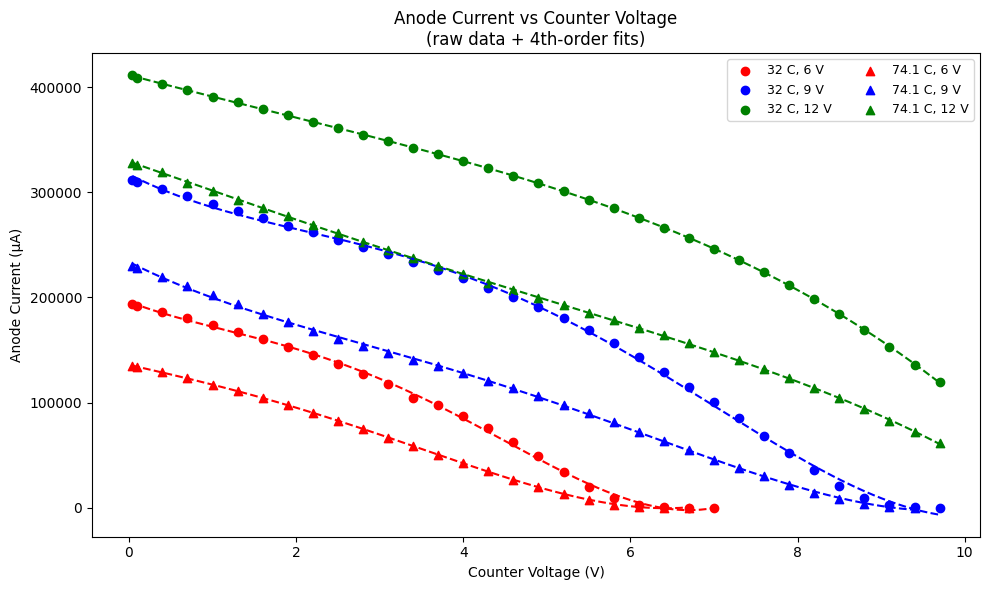

In [60]:
# --------------------------------------------------------------------------
# 1)  SETTINGS
# --------------------------------------------------------------------------
y_columns = ['Anode Current (6V) [µA]',
             'Anode Current (9V) [µA]',
             'Anode Current (12V) [µA]']

color_map  = {6: 'red', 9: 'blue', 12: 'green'}
marker_map = {'32 C': 'o', '74.1 C': '^'}
out_csv    = Path('fit_coefficients.csv')

# --------------------------------------------------------------------------
# 2)  FIT ALL CURVES  (4th-order poly, numpy.polyfit)
# --------------------------------------------------------------------------
fit_results = {}          # fit_results[temp][voltage] -> [a,b,c,d,e]
rows        = []          # rows for the CSV

for temp_key, df in data_dict.items():              # e.g. '32 C', '74.1 C'
    fit_results[temp_key] = {}
    x_all = df['Counter Voltage'].values

    for y_col in y_columns:
        volts = int(re.search(r'\((\d+)V', y_col).group(1))     # 6, 9, 12
        y_all = df[y_col].values
        mask  = ~np.isnan(y_all)
        x, y  = x_all[mask], y_all[mask]

        coeffs_desc = np.polyfit(x, y, 4)    # [e,d,c,b,a]
        a, b, c, d, e = coeffs_desc[::-1]    # reverse → [a,b,c,d,e]

        fit_results[temp_key][volts] = [a, b, c, d, e]
        rows.append({'Temperature': temp_key, 'Voltage': f'{volts} V',
                     'a': a, 'b': b, 'c': c, 'd': d, 'e': e})

# save / show coefficient table
coeff_table = pd.DataFrame(rows)
coeff_table.to_csv(out_csv, index=False)
print(coeff_table)

# --------------------------------------------------------------------------
# 3)  PLOT RAW DATA + FIT CURVES
# --------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(xlabel='Counter Voltage (V)',
       ylabel='Anode Current (µA)',
       title='Anode Current vs Counter Voltage\n(raw data + 4th-order fits)')

for temp_key, df in data_dict.items():
    x_all = df['Counter Voltage'].values

    for y_col in y_columns:
        volts = int(re.search(r'\((\d+)V', y_col).group(1))
        y_all = df[y_col].values
        mask  = ~np.isnan(y_all)
        x, y  = x_all[mask], y_all[mask]

        # scatter raw points
        ax.scatter(x, y,
                   color=color_map[volts],
                   marker=marker_map[temp_key],
                   label=f'{temp_key}, {volts} V')

        # fitted curve
        a, b, c, d, e = fit_results[temp_key][volts]
        x_fit = np.linspace(x.min(), x.max(), 400)
        y_fit = a + b*x_fit + c*x_fit**2 + d*x_fit**3 + e*x_fit**4
        ax.plot(x_fit, y_fit,
                color=color_map[volts],
                linestyle='--', linewidth=1.5)

# prune duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys(), ncol=2, fontsize=9)

plt.tight_layout()
plt.show()